In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.abspath(''), "..")))
import example_package

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def PlotWeights_simple(weights, epoch):
    plt.figure(figsize=(8, 6))
    plt.imshow(weights, cmap='viridis', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title(f'Weight Matrix at Epoch {epoch}')
    plt.xlabel('Units')
    plt.ylabel('Units')
    plt.show()

def PlotWeights(model, epoch):
    # Get the weight matrix
    weight_matrix = model.w.detach().cpu().numpy()
    
    # Define the structure of the network
    nv1 = model.nv // 2  # Number of visible units
    nv2 = model.nv // 2  # Number of visible units
    nh = model.nh        # Number of hidden units
    
    # Create a figure for the entire network
    fig, axes = plt.subplots(nv1 + nh + nv2, 1, figsize=(10, 2 * (nv1 + nh + nv2)))
    
    # Define labels for the units
    unit_labels = [f'V1_{i+1}' for i in range(nv1)] + \
                    [f'H_{i+1}' for i in range(nh)] + \
                    [f'V2_{i+1}' for i in range(nv2)]
    
    # Iterate over each unit and plot its connections
    for i in range(model.n):
        ax = axes[i]
        unit_weights = weight_matrix[i, :]
        unit_weights_grid = unit_weights.reshape(1, -1)  # Reshape to (1, 10)
        im = ax.imshow(unit_weights_grid, cmap='viridis', vmin=-1, vmax=1, aspect='auto')
        ax.set_xticks(range(model.n))
        ax.set_xticklabels(unit_labels, rotation=90)
        ax.set_title(f'Unit {i+1} ({unit_labels[i]}) Connections')
        ax.set_yticks([])
        plt.colorbar(im, ax=ax)
        
        for j in range(model.n):
            if j < nv1:
                ax.axvspan(j - 0.5, j + 0.5, color='lightblue', alpha=0.3)  # V1 units
            elif j < nv1 + nh:
                ax.axvspan(j - 0.5, j + 0.5, color='lightgreen', alpha=0.3)  # Hidden units
            else:
                ax.axvspan(j - 0.5, j + 0.5, color='lightcoral', alpha=0.3)  # V2 units
    
    plt.tight_layout()
    plt.suptitle(f'Weight Visualization at Epoch {epoch}', y=1.02)
    plt.show()

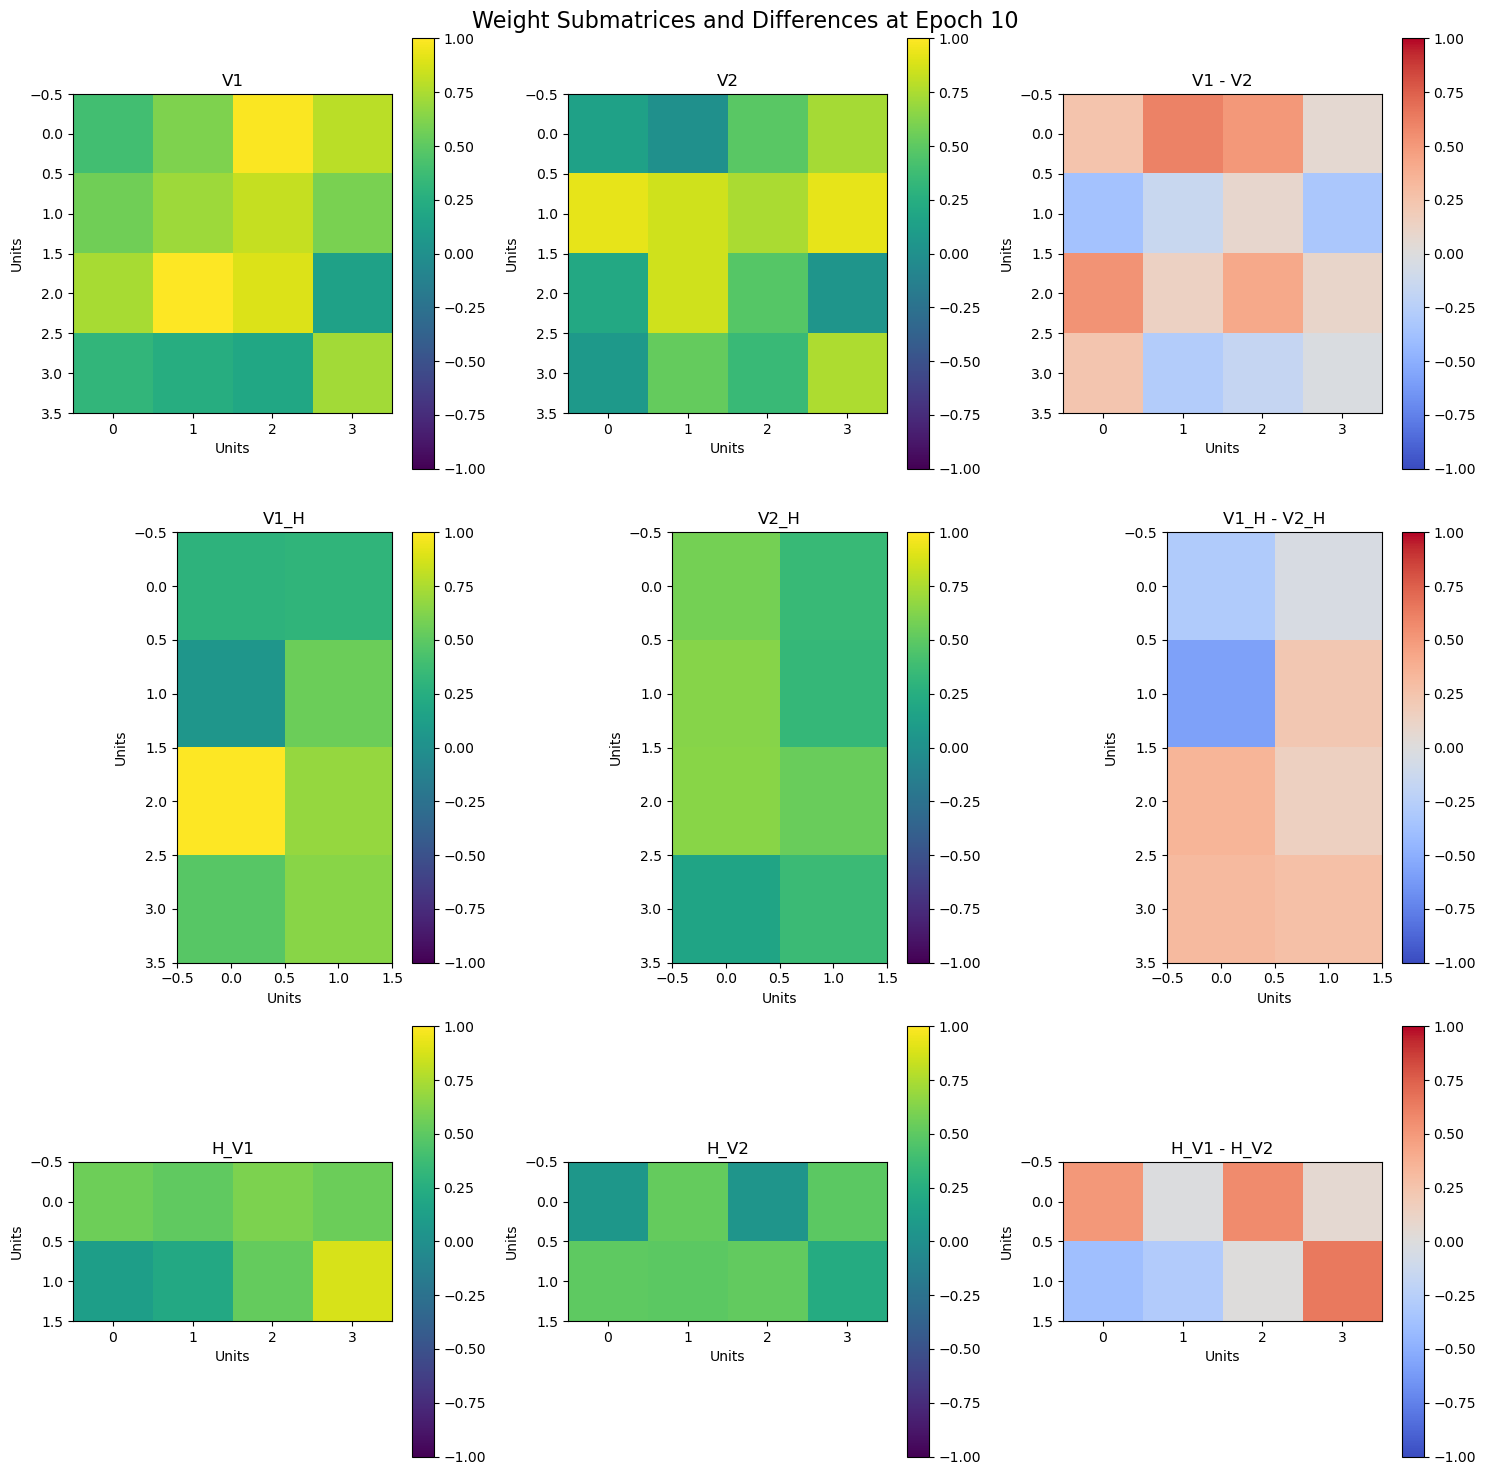

(np.float64(1.265795574496083),
 np.float64(0.8907503385460743),
 np.float64(1.105755733220232))

In [14]:
def compute_symmetry(matrix_1, matrix_2):
    return np.linalg.norm(matrix_1 - matrix_2, ord='fro')

def plot_matrices_and_difference(ax_row, matrix_1, matrix_2, title_1, title_2):
    # Plot the first matrix
    im1 = ax_row[0].imshow(matrix_1, cmap='viridis', vmin=-1, vmax=1)
    ax_row[0].set_title(title_1)
    ax_row[0].set_xlabel('Units')
    ax_row[0].set_ylabel('Units')
    plt.colorbar(im1, ax=ax_row[0])
    
    # Plot the second matrix
    im2 = ax_row[1].imshow(matrix_2, cmap='viridis', vmin=-1, vmax=1)
    ax_row[1].set_title(title_2)
    ax_row[1].set_xlabel('Units')
    ax_row[1].set_ylabel('Units')
    plt.colorbar(im2, ax=ax_row[1])
    
    # Plot the difference between the two matrices
    diff = matrix_1 - matrix_2
    im3 = ax_row[2].imshow(diff, cmap='coolwarm', vmin=-1, vmax=1)
    ax_row[2].set_title(f'{title_1} - {title_2}')
    ax_row[2].set_xlabel('Units')
    ax_row[2].set_ylabel('Units')
    plt.colorbar(im3, ax=ax_row[2])

def analyze_symmetry(weight_matrix, nv, nh,  epoch):
    # Define the structure of the network
    nv1 = nv//2  # Number of visible units in V1
    nv2 = nv//2  # Number of visible units in V2
    nh = 2   # Number of hidden units
    
    # Extract submatrices
    V1 = weight_matrix[:nv1, :nv1]  # V1 to V1 connections
    V2 = weight_matrix[nv1:nv1+nv2, nv1:nv1+nv2]  # V2 to V2 connections
    V1_H = weight_matrix[:nv1, nv1+nv2:nv1+nv2+nh]  # V1 to H connections
    V2_H = weight_matrix[nv1:nv1+nv2, nv1+nv2:nv1+nv2+nh]  # V2 to H connections
    H_V1 = weight_matrix[nv1+nv2:nv1+nv2+nh, :nv1]  # H to V1 connections
    H_V2 = weight_matrix[nv1+nv2:nv1+nv2+nh, nv1:nv1+nv2]  # H to V2 connections
    
    symmetry_V1_V2 = compute_symmetry(V1, V2)
    symmetry_V1_H_V2_H = compute_symmetry(V1_H, V2_H)
    symmetry_H_V1_H_V2 = compute_symmetry(H_V1, H_V2)
    
    return symmetry_V1_V2, symmetry_V1_H_V2_H, symmetry_H_V1_H_V2

def visualize_symmetry(weight_matrix, nv, nh, epoch):
    
    nv1 = nv // 2
    nv2 = nv // 2 
    
    # Extract submatrices
    V1 = weight_matrix[:nv1, :nv1]  # V1 to V1 connections
    V2 = weight_matrix[nv1:nv1+nv2, nv1:nv1+nv2]  # V2 to V2 connections
    V1_H = weight_matrix[:nv1, nv1+nv2:nv1+nv2+nh]  # V1 to H connections
    V2_H = weight_matrix[nv1:nv1+nv2, nv1+nv2:nv1+nv2+nh]  # V2 to H connections
    H_V1 = weight_matrix[nv1+nv2:nv1+nv2+nh, :nv1]  # H to V1 connections
    H_V2 = weight_matrix[nv1+nv2:nv1+nv2+nh, nv1:nv1+nv2]  # H to V2 connections
    
    symmetry_V1_V2 = compute_symmetry(V1, V2)
    symmetry_V1_H_V2_H = compute_symmetry(V1_H, V2_H)
    symmetry_H_V1_H_V2 = compute_symmetry(H_V1, H_V2)
    
    # Visualize the submatrices and their differences
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    fig.suptitle(f'Weight Submatrices and Differences at Epoch {epoch}', fontsize=16)
    
    plot_matrices_and_difference(axes[0], V1, V2, 'V1', 'V2')
    plot_matrices_and_difference(axes[1], V1_H, V2_H, 'V1_H', 'V2_H')
    plot_matrices_and_difference(axes[2], H_V1, H_V2, 'H_V1', 'H_V2')
    
    plt.tight_layout()
    plt.show()
    
    return symmetry_V1_V2, symmetry_V1_H_V2_H, symmetry_H_V1_H_V2

# Example usage
weight_matrix = np.random.rand(10, 10) 
nv = 8
nh = 2
epoch = 10
visualize_symmetry(weight_matrix, nv, nh, epoch)

analyze_symmetry(weight_matrix, 8,2, epoch)

In [ ]:
stage_length_epochs = [5,10,20]
total_epochs =0
for epochs in stage_length_epochs:
    total_epochs += epochs
    example_package.TrainBatch(...)
    PlotWeights(model,total_epochs)

TypeError: TrainBatch() missing 5 required positional arguments: 'data', 'epochs', 'learningRate', 'noise_levels', and 'T'